#M2 DSAI, GMMs

In [88]:
install.packages("mvtnorm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [89]:
library(MASS)
library(mvtnorm)

We want to sample from a GMM using the latent variable formulation, for each $i \in \{1, \ldots, n\}$, we sample:
- $k_i \sim \text{Bern}( \pi )$
- $x_i \sim \mathcal{N}( \mu_{k_i},\Sigma_{k_i}) $,

where $\pi \in (0,1)$, $\mu_{0},\mu_{1} \in \mathbb{R}^D$, and $\Sigma_0, \Sigma_1 \in \mathcal{S}_D^{++}$, the set of positive definite matrices.

In [66]:
n = 300
D = 2

In [67]:
Pi = 0.7

In [68]:
mu_0 = c(2,2)
mu_1 = c(-2,-2)

In [69]:
S_0 = rbind(c(1,0.5),c(0.5,1))
S_1 = rbind(c(1,0),c(0,1))

To sample from a Bernoulli, we can sample from a binomial with $\texttt{size}=1$, this way:

In [70]:
rbinom(n = 1,size = 1, prob = Pi)

[1] 1

To sample from a mutivariate Gaussian, we can just use this function from the MASS package:

In [71]:
mvrnorm(n=1,mu_0,S_0)

[1] 2.679756 2.943079

Now, we have all the tools we need to sample from the GMM. Our final data matrix $X$ will be of size $n \times 2$.

In [72]:
X = matrix(nrow = n, ncol = 2) # creating an empty matrix

In [73]:
for (i in 1:n){
  k = rbinom(n = 1,size = 1, prob = Pi) # sample from a Bernoulli

  if (k==0){
    X[i,] = mvrnorm(n=1,mu_0,S_0)
  }

  if (k==1){
    X[i,] = mvrnorm(n=1,mu_1,S_1)
  }

}

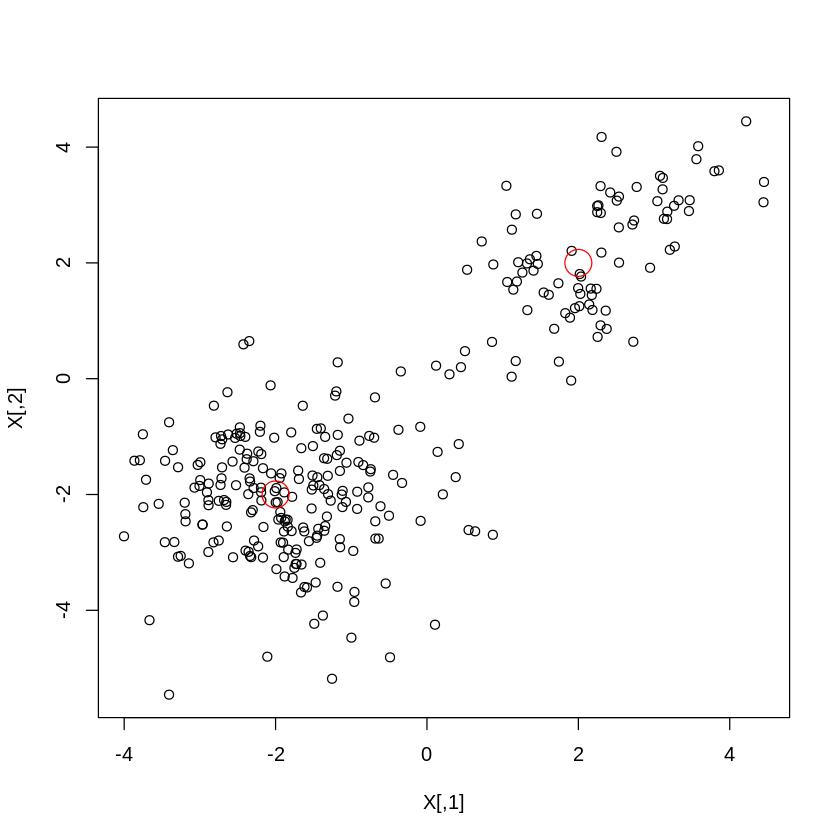

In [74]:
plot(X)
points(x=c(mu_0[1],mu_1[1]),y=c(mu_0[2],mu_1[2]), col = "red", cex=3)

Now let's do the same with $K =4$:

In [75]:
Pis = c(0.7,0.1,0.1,0.1)

mu_1 = c(10,10)
mu_2 = c(20,20)
mu_3 = c(30,30)
mu_4 = c(40,40)

S_1 = rbind(c(1,0.5),c(0.5,1))
S_2 = S_1
S_3 = S_1
S_4 = S_1

We can sample from a categorical (aka multinomial with $\texttt{size}=1$) distribution using

In [76]:
rmultinom(n = 1, size = 1, prob = Pis)

1
0
0
0


Note that is a one-hot encoding of the latent variable.

In [78]:
X = matrix(nrow = n, ncol = 2) # creating an empty matrix

for (i in 1:n){

  k = rmultinom(n = 1, size = 1, prob = Pis)

  if (k[1]==1){
    X[i,] = mvrnorm(n=1,mu_1,S_1)
  }

  if (k[2]==1){
    X[i,] = mvrnorm(n=1,mu_2,S_2)
  }

  if (k[3]==1){
    X[i,] = mvrnorm(n=1,mu_3,S_3)
  }

  if (k[4]==1){
    X[i,] = mvrnorm(n=1,mu_4,S_4)
  }

}

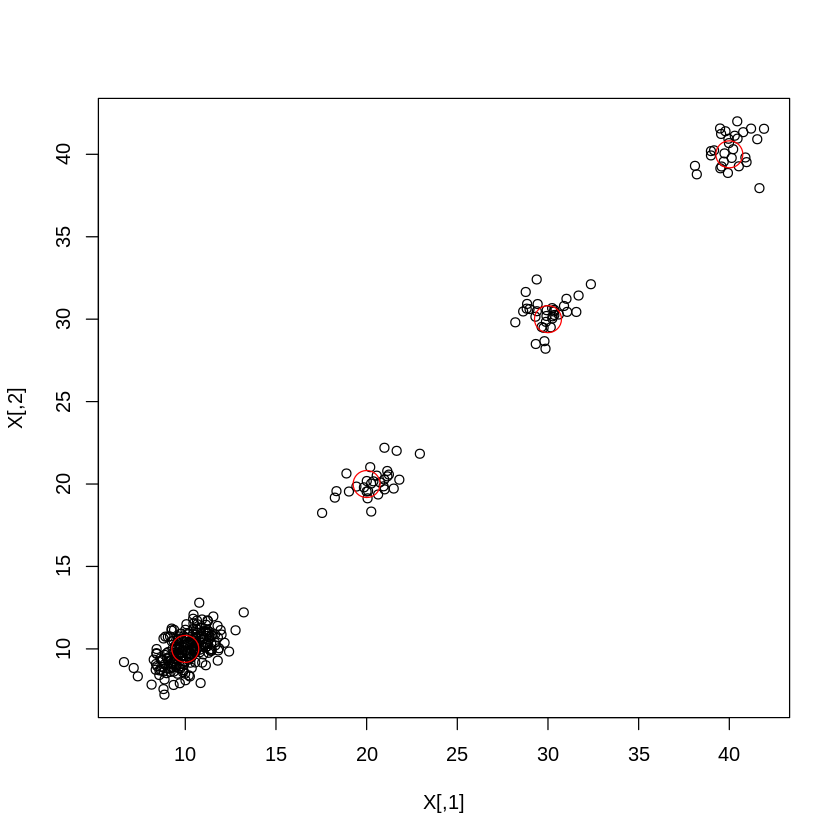

In [79]:
plot(X)
points(x=c(mu_1[1],mu_2[1],mu_3[1],mu_4[1]),y=c(mu_1[2],mu_2[2],mu_3[2],mu_4[2]), col = "red", cex=3)

Now let's use the function last week to learn the parameters!

In [90]:
EM_GMM <- function(X,K,max_it=50){
  # Initialization
  p = ncol(X)
  n = nrow(X)
  prop = rep(NA,K)
  mu = matrix(NA,K,p)
  Sigma = array(NA,dim = c(K,p,p))

  # Random init
  T = t(rmultinom(n,K,rep(1/K,K)))

  # The EM loop
  for (it in 1:max_it){       cat('.')
    # M step
    for (k in 1:K){
      nk = sum(T[,k])
      prop[k] = nk / n
      mu[k,] = 1/nk * colSums(T[,k] %*% matrix(1,1,p) * X)
      Ak = T[,k] * as.matrix(X - matrix(1,n,1)%*%mu[k,])
      Bk = as.matrix(X - matrix(1,n,1)%*%mu[k,])
      Sigma[k,,] = 1/nk * t(Ak) %*% Bk
    }
    # E step
    for (k in 1:K) T[,k] = prop[k] * dmvnorm(X,mu[k,],Sigma[k,,])
    T = T / rowSums(T) %*% matrix(1,1,K)
    # Visualization
    plot(X,pch=19,col=max.col(T))
    for(k in 1:K) points(mu[k,1],mu[k,2],pch="*",cex=5,col=k)
    Sys.sleep(0.25)
  }
  return(list(prop=prop,mu=mu,Sigma=Sigma,T=T))
}

..

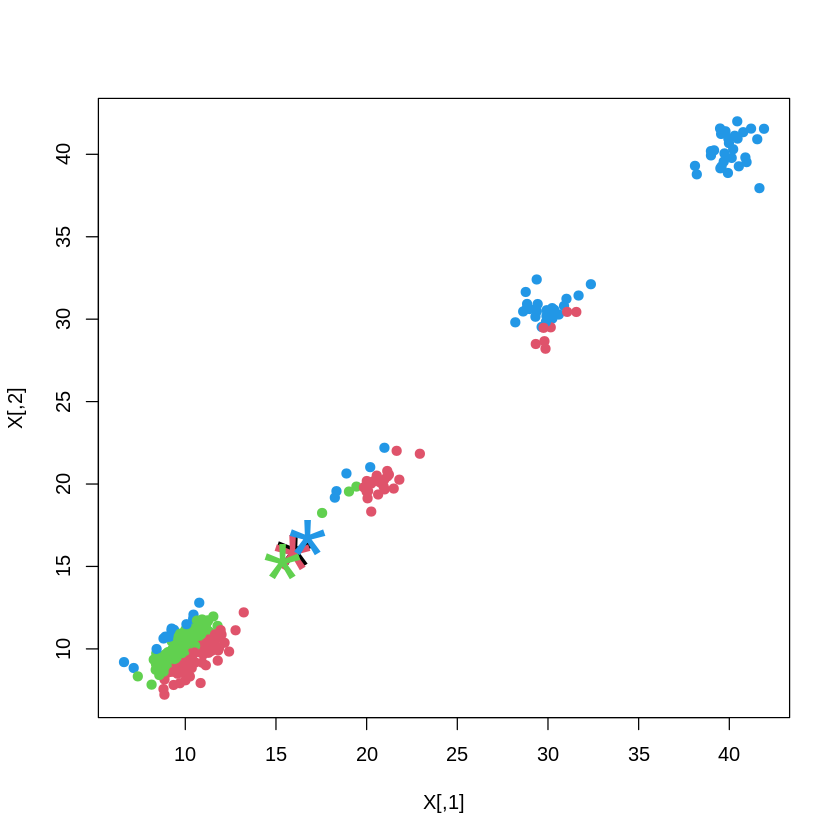

.

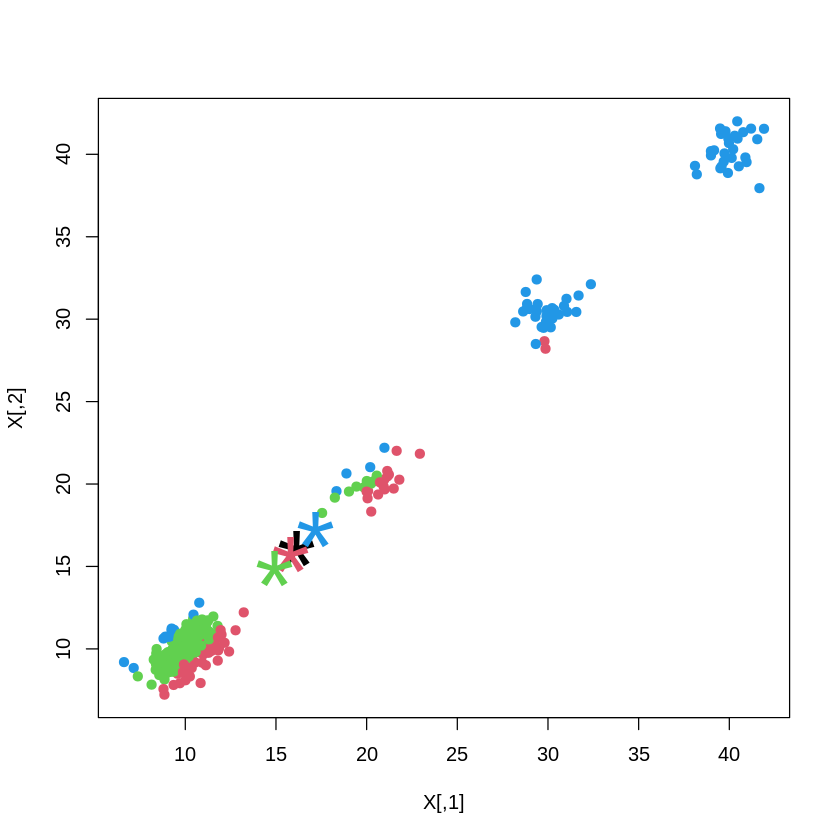

.

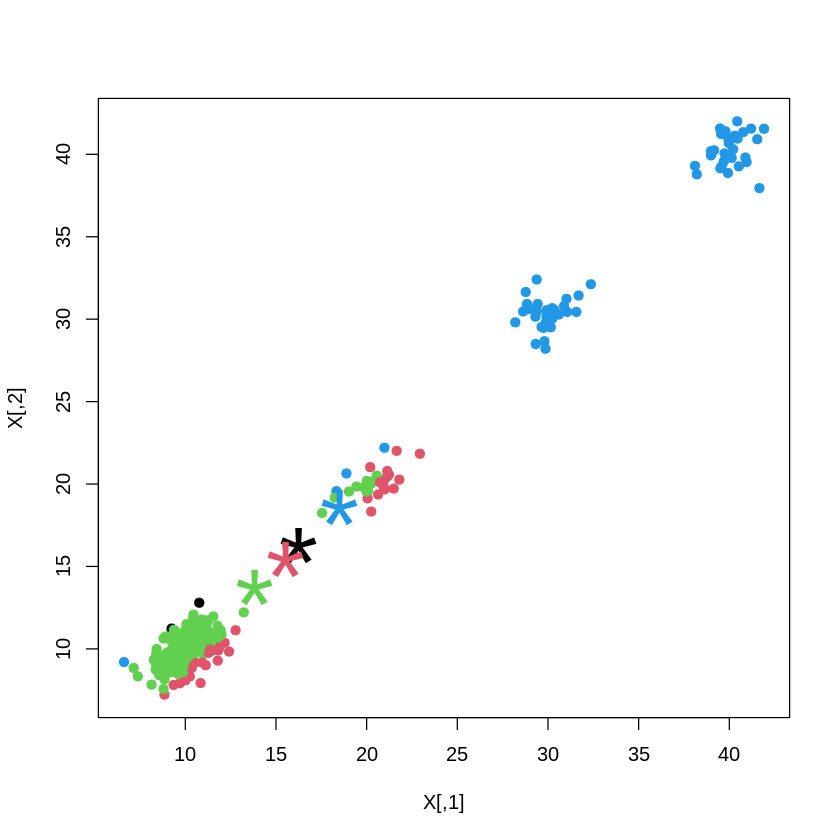

.

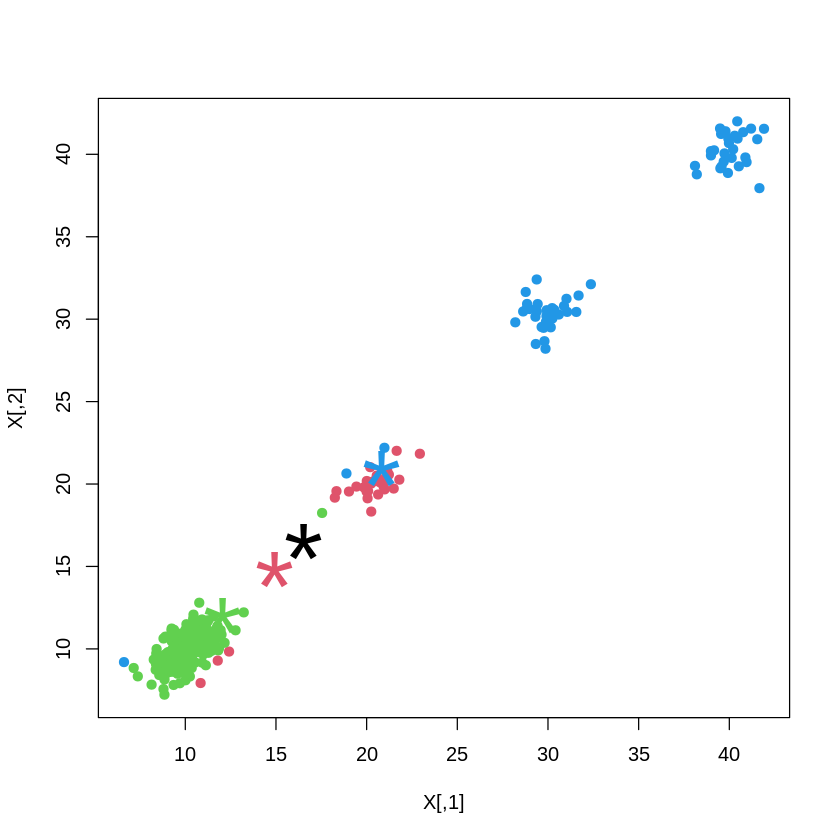

.

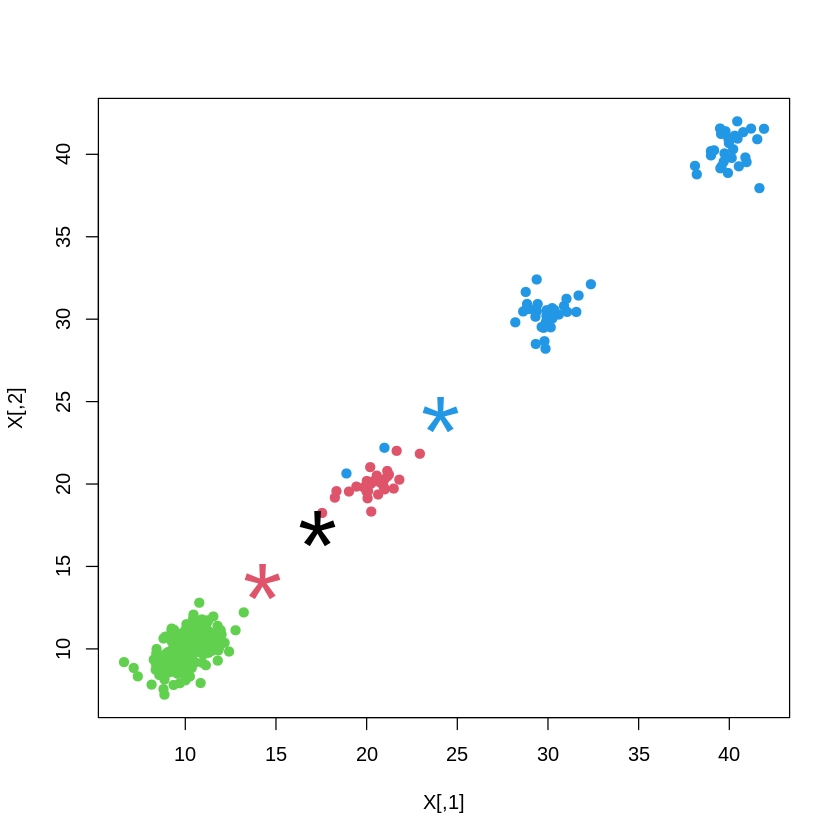

.

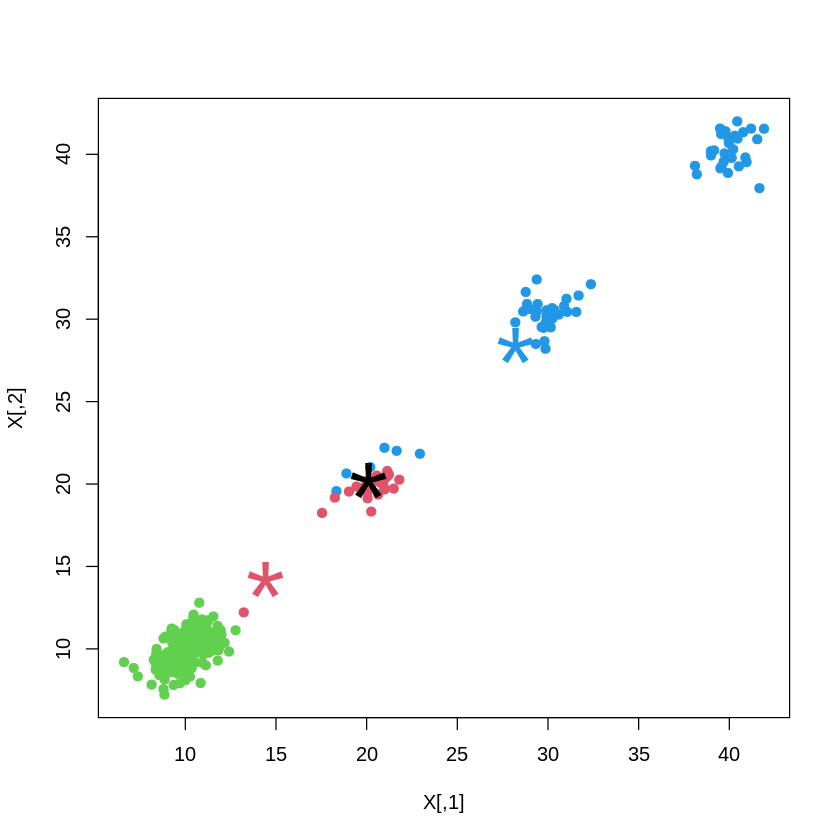

.

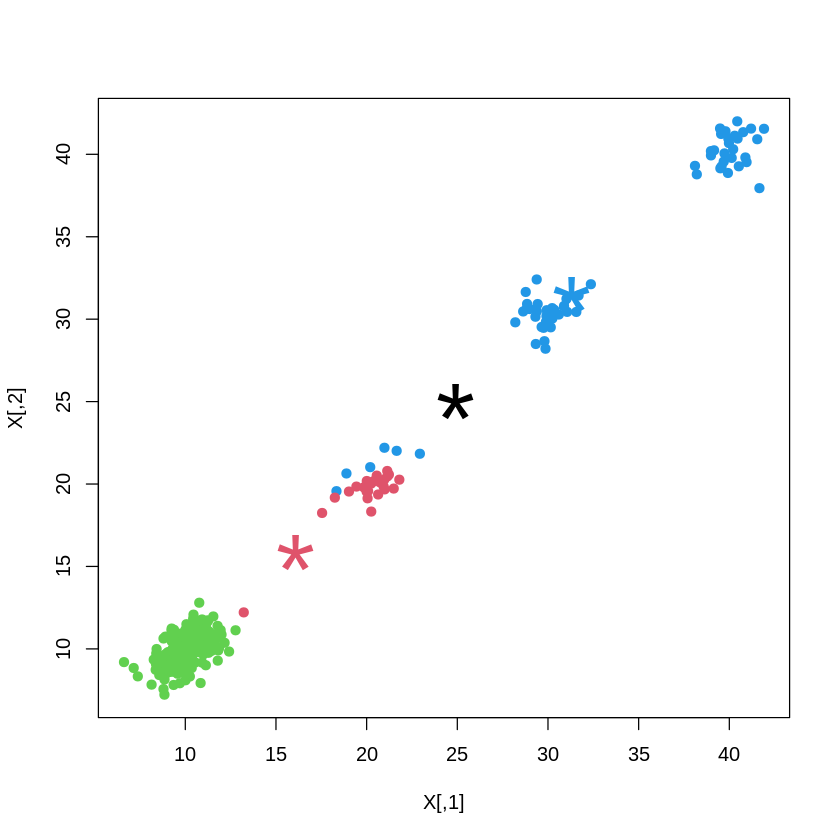

.

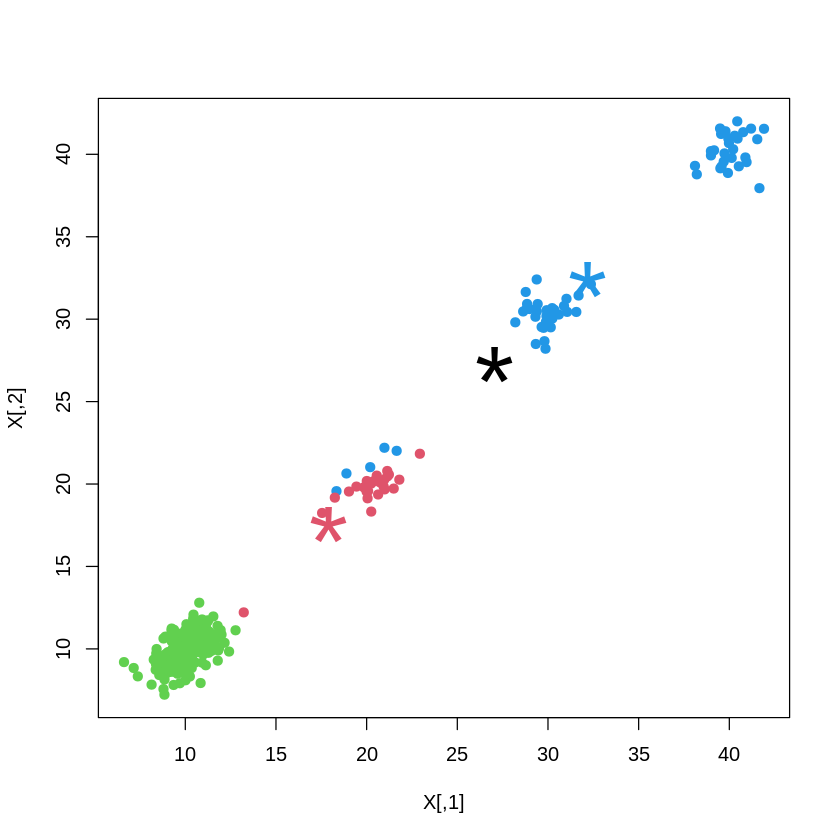

.

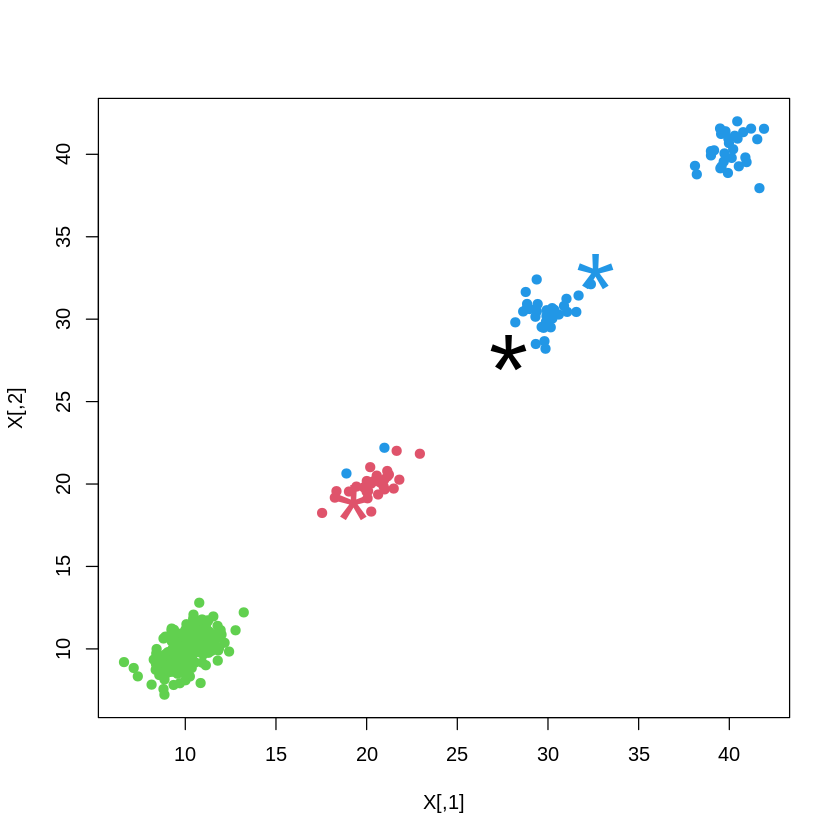

.

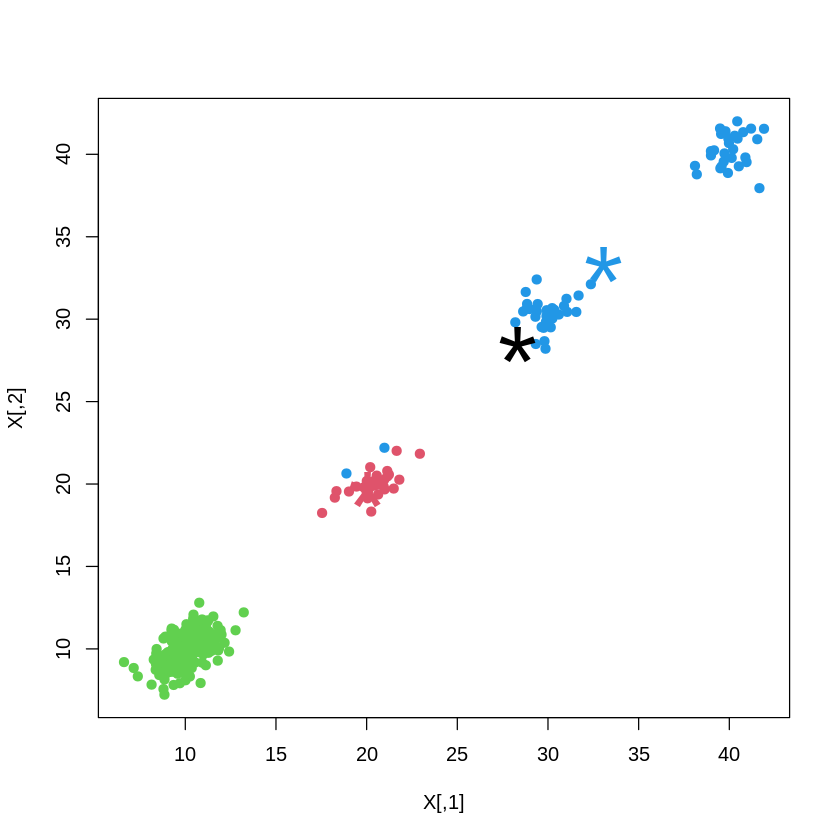

.

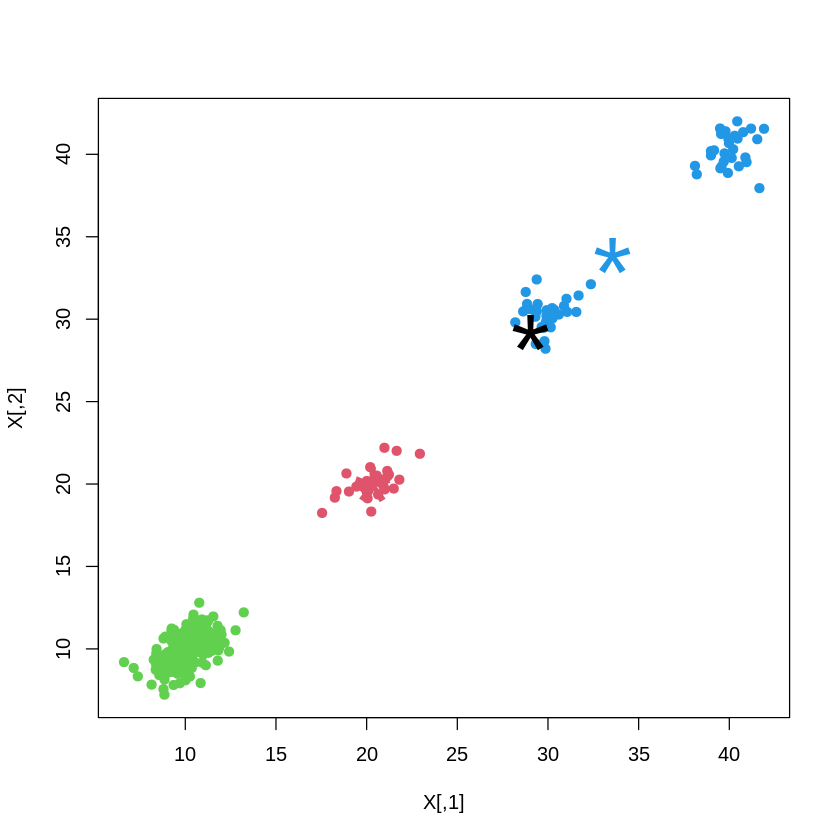

.

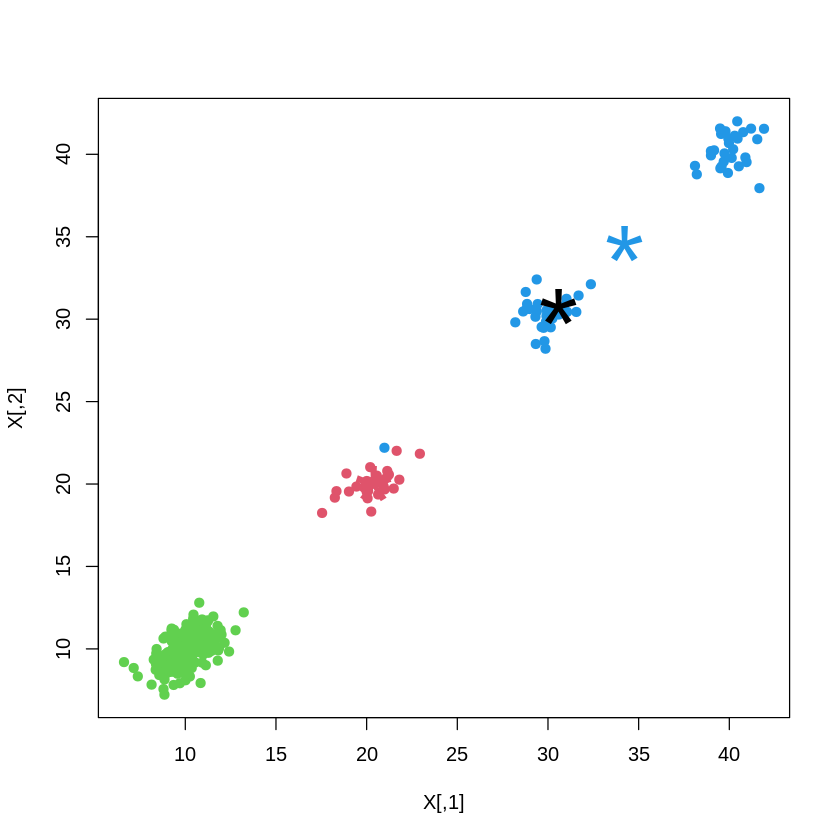

.

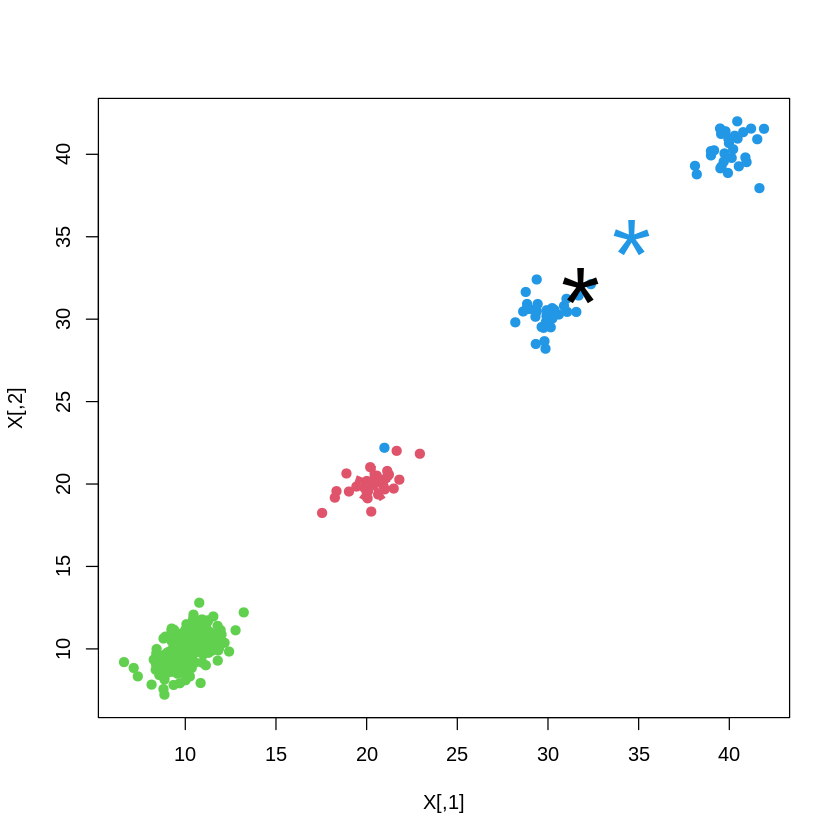

.

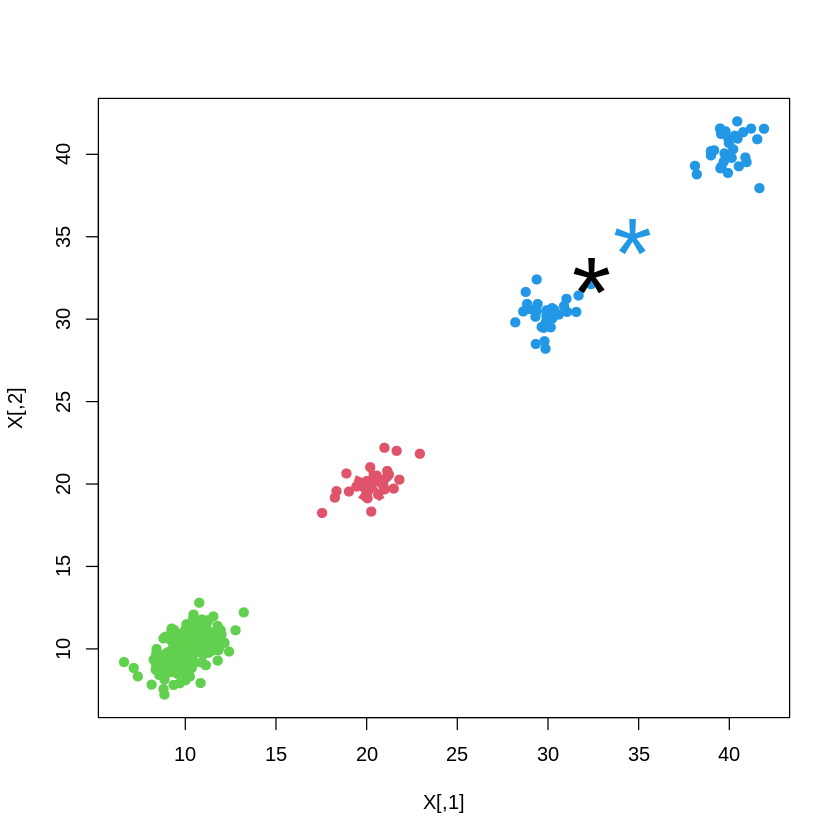

.

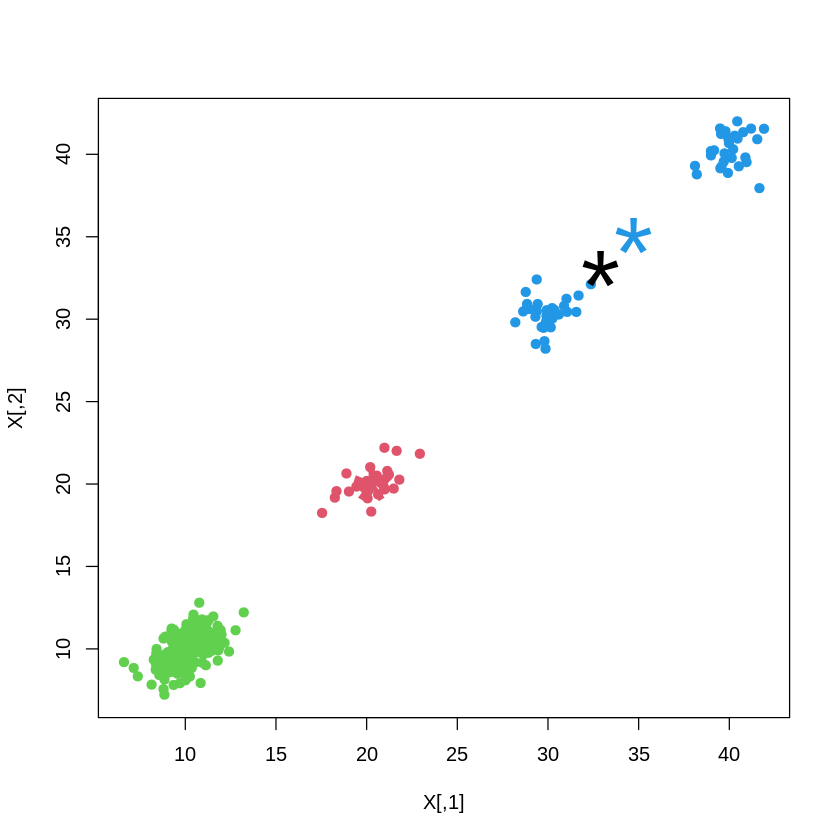

.

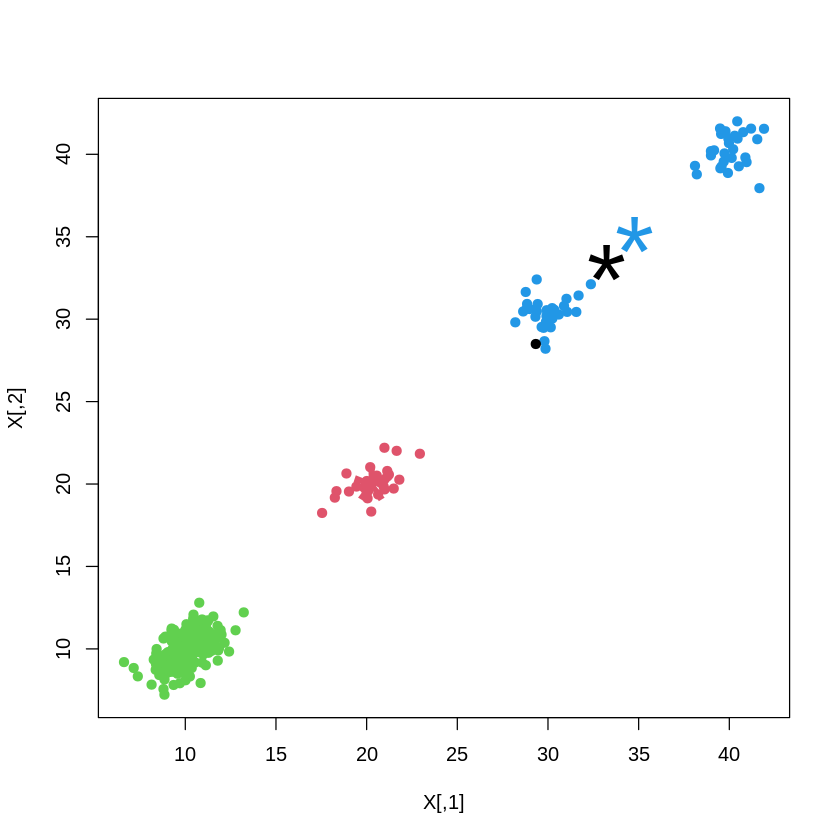

.

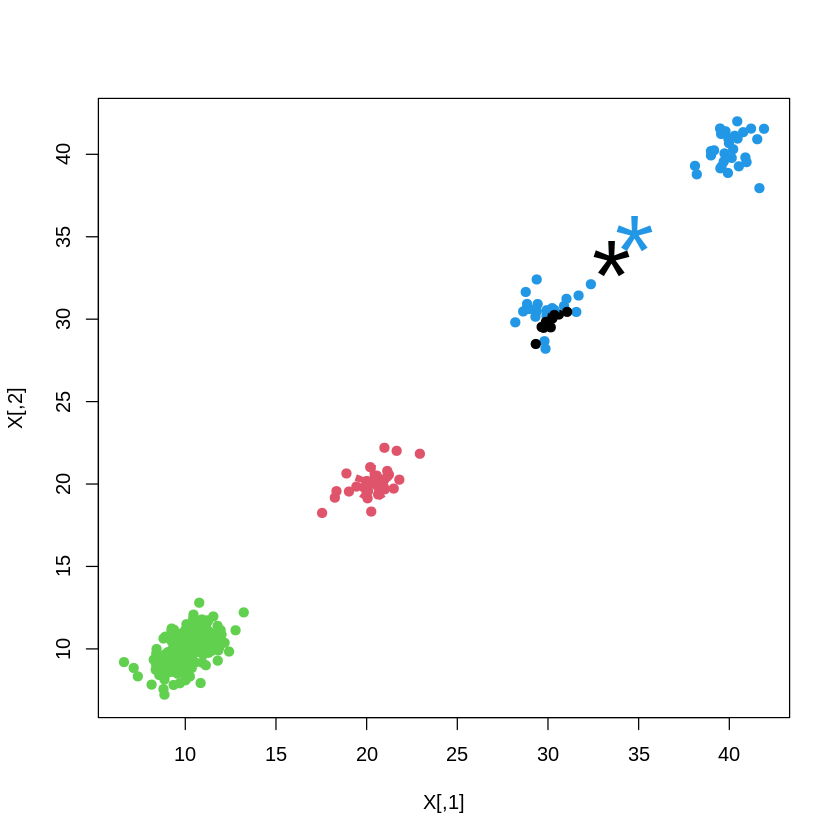

.

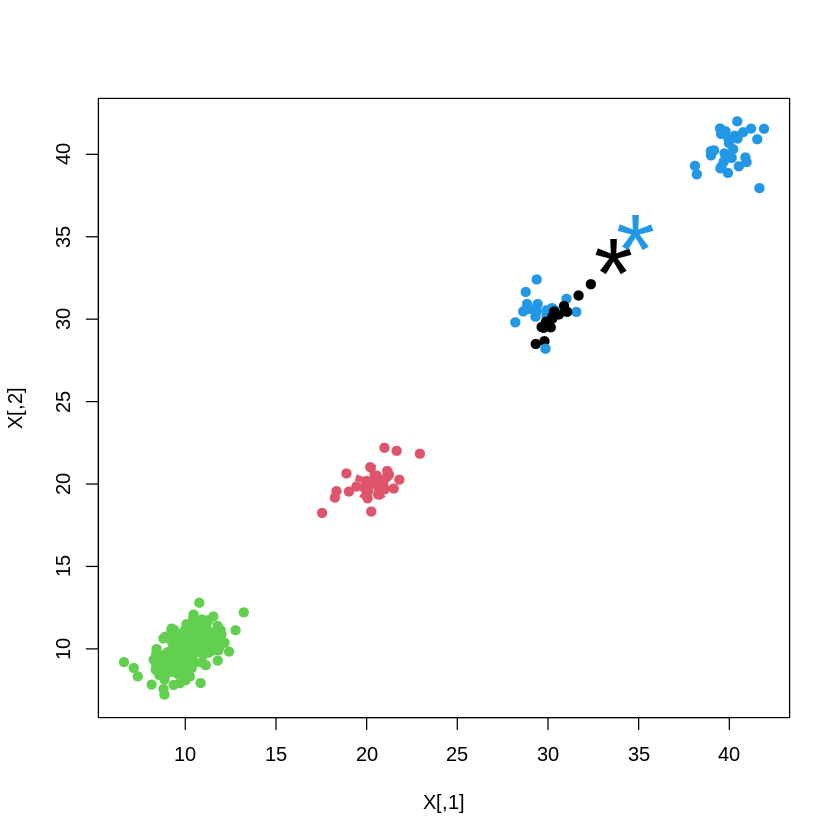

In [95]:
out = EM_GMM(X,K=4, max_it=150)

In [97]:
out$T

8.133704e-01,0.000000e+00,0.0009211824,1.857084e-01
9.253981e-01,0.000000e+00,0.0014106032,7.319132e-02
4.100210e-01,0.000000e+00,0.0054588682,5.845201e-01
6.959452e-01,0.000000e+00,0.0008291413,3.032257e-01
1.094549e-36,4.692079e-149,1.0000000000,2.446286e-38
8.042531e-01,0.000000e+00,0.0003508449,1.953960e-01
7.633019e-01,0.000000e+00,0.0006741607,2.360239e-01
2.964459e-305,9.923859e-01,0.0076141217,0.000000e+00
2.559137e-124,6.850732e-44,1.0000000000,2.634377e-139
7.004772e-01,0.000000e+00,0.0004348016,2.990880e-01
8.997072e-02,0.000000e+00,0.0004009096,9.096284e-01
